<a href="https://colab.research.google.com/github/yahia-kplr/Machine-Learning/blob/main/RL_FR_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutoriel TensorFlow #16
# Apprentissage par renforcement (Q-Learning)
par [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials)

## Introduction
Ce didacticiel porte sur ce que l'on appelle l'apprentissage par renforcement dans lequel un agent apprend à naviguer dans un environnement, dans ce cas les jeux Atari des années 1970-80. L'agent ne connaît rien au jeu et doit apprendre à y jouer par essais et erreurs. La seule information disponible pour l'agent est la sortie d'écran du jeu et si l'action précédente a entraîné une récompense ou une pénalité.
Il s'agit d'un problème très difficile en Machine Learning / Intelligence Artificielle, car l'agent doit à la fois apprendre à distinguer les caractéristiques dans les images du jeu, puis relier l'occurrence de certaines caractéristiques dans les images du jeu avec ses propres actions et une récompense ou une pénalité qui peut être reporté de nombreuses étapes dans le futur.
Ce problème a d'abord été résolu par les chercheurs de Google DeepMind. Ce didacticiel est basé sur les idées principales de leurs premiers articles de recherche (en particulier [this](https://arxiv.org/abs/1312.5602) et [this](https://arxiv.org/abs/1312.5602)), bien que nous apportions plusieurs modifications car l'algorithme original de DeepMind était maladroit et trop compliqué à certains égards. Mais il s'avère que vous avez encore besoin de plusieurs astuces pour stabiliser l'entraînement de l'agent, donc la mise en œuvre dans ce tutoriel est malheureusement aussi quelque peu compliquée.
L'idée de base est de demander à l'agent d'estimer les soi-disant valeurs Q chaque fois qu'il voit une image de l'environnement du jeu. Les valeurs Q indiquent à l'agent quelle action est la plus susceptible de conduire à la récompense cumulée la plus élevée à l'avenir. Le problème est alors réduit à trouver ces valeurs Q et à les stocker pour une récupération ultérieure à l'aide d'un approximateur de fonction.
Cela s'appuie sur certains des tutoriels précédents. Vous devez être familiarisé avec TensorFlow et les réseaux de neurones convolutifs des didacticiels 01 et 02. Il sera également utile si vous connaissez l'une des API de constructeur dans les didacticiels #03 ou #03-B.

## Le problème
Ce didacticiel utilise le jeu Atari Breakout, où le joueur ou l'agent est censé frapper une balle avec une raquette, évitant ainsi la mort tout en marquant des points lorsque la balle fracasse des morceaux d'un mur.
Lorsqu'un humain apprend à jouer à un jeu comme celui-ci, la première chose à déterminer est quelle partie de l'environnement de jeu vous contrôlez - dans ce cas, la palette en bas. Si vous vous déplacez vers la droite sur le joystick, la palette se déplace vers la droite et vice versa. La prochaine chose est de comprendre quel est le but du jeu - dans ce cas, casser autant de briques dans le mur que possible afin de maximiser le score. Enfin, vous devez apprendre ce qu'il faut éviter - dans ce cas, vous devez éviter de mourir en laissant passer la balle à côté de la raquette.
Vous trouverez ci-dessous 3 images du jeu qui montrent ce que nous avons besoin que notre agent apprenne. Dans l'image de gauche, la balle descend et l'agent doit apprendre à déplacer la raquette pour frapper la balle et éviter la mort. L'image du milieu montre la raquette frappant la balle, ce qui conduit finalement à l'image de droite où la balle brise des briques et marque des points. La balle continue ensuite vers le bas et le processus se répète.

![Illustration of the problem](https://github.com/mehdi-lamrani/Neural-Networks/blob/main/images/16_problem.png?raw=1)

Le problème est qu'il y a 10 états entre la balle qui descend et la raquette qui frappe la balle, et il y a 18 états supplémentaires avant que la récompense ne soit obtenue lorsque la balle frappe le mur et brise des briques. Comment apprendre à un agent à relier ces trois situations et à généraliser à des situations similaires ? La réponse est d'utiliser ce qu'on appelle l'apprentissage par renforcement avec un réseau de neurones, comme indiqué dans ce didacticiel.

## Q-Apprentissage

L'un des moyens les plus simples de faire de l'apprentissage par renforcement s'appelle le Q-learning. Ici, nous voulons estimer les soi-disant valeurs Q qui sont également appelées valeurs d'action, car elles mappent un état de l'environnement de jeu à une valeur numérique pour chaque action possible que l'agent peut entreprendre. Les valeurs Q indiquent quelle action devrait entraîner la récompense future la plus élevée, indiquant ainsi à l'agent quelle action entreprendre.
Malheureusement, nous ne savons pas quelles sont les valeurs Q supposées être, nous devons donc les estimer d'une manière ou d'une autre. Les valeurs Q sont toutes initialisées à zéro, puis mises à jour à plusieurs reprises au fur et à mesure que de nouvelles informations sont collectées auprès de l'agent jouant au jeu. Lorsque l'agent marque un point, la valeur Q doit être mise à jour avec les nouvelles informations.
Il existe différentes formules pour mettre à jour les valeurs Q, mais la plus simple consiste à définir la nouvelle valeur Q sur la récompense observée, plus la valeur Q maximale pour l'état suivant du jeu. Cela donne la récompense totale à laquelle l'agent peut s'attendre à partir de l'état actuel du jeu et au-delà. En règle générale, nous multiplions également la valeur Q maximale pour l'état suivant par un soi-disant facteur de réduction légèrement inférieur à 1. Cela fait que les récompenses plus éloignées contribuent moins à la valeur Q, ce qui oblige l'agent à privilégier les récompenses plus proches dans le temps. .
La formule de mise à jour de la valeur Q est :
Valeur Q pour l'état et l'action = récompense + remise * valeur Q max pour l'état suivant
Dans les articles universitaires, cela est généralement écrit avec des symboles mathématiques comme celui-ci :
$$
Q(s_{t},a_{t}) \leftarrow \underbrace{r_{t}}_{\rm récompense} + \underbrace{\gamma}_{\rm remise} \cdot \underbrace{\max_{a }Q(s_{t+1}, a)}_{\rm estimation~des~futures~récompenses}
$$
De plus, lorsque l'agent perd une vie, nous savons que la récompense future est nulle car l'agent est mort, nous définissons donc la valeur Q pour cet état sur zéro.

### Exemple simple
Les images ci-dessous montrent comment les valeurs Q sont mises à jour dans un balayage en arrière à travers les états de jeu qui ont été précédemment visités. Dans cet exemple simple, nous supposons que toutes les valeurs Q ont été initialisées à zéro. L'agent obtient une récompense de 1 point dans l'image la plus à droite. Cette récompense est ensuite propagée vers les états de jeu précédents, donc lorsque nous voyons des états de jeu similaires à l'avenir, nous savons que les actions données ont entraîné cette récompense.
L'actualisation est une fonction exponentiellement décroissante. Cet exemple utilise un facteur de réduction de 0,97, donc la valeur Q pour la 3ème image est d'environ 0,885 $ \simeq 0,97^4$ car c'est 4 états avant l'état qui a effectivement reçu la récompense. De même pour les autres états. Cet exemple ne montre qu'une valeur Q par état, mais en réalité il y a une valeur Q pour chaque action possible dans l'état, et les valeurs Q sont mises à jour dans un balayage arrière en utilisant la formule ci-dessus. Ceci est illustré dans la section suivante.

![Q-values Simple Example](https://github.com/mehdi-lamrani/Neural-Networks/blob/main/images/16_q-values-simple.png?raw=1)

### Exemple détaillé
Ceci est un exemple plus détaillé montrant les valeurs Q pour deux états successifs de l'environnement de jeu et comment les mettre à jour.

![Q-values Detailed Example](https://github.com/mehdi-lamrani/Neural-Networks/blob/main/images/16_q-values-details.png?raw=1)

Les valeurs Q pour les actions possibles ont été estimées par un réseau de neurones. Pour l'action NOOP dans l'état $t$, la valeur Q est estimée à 2,900, qui est la valeur Q la plus élevée pour cet état, donc l'agent prend cette action, c'est-à-dire que l'agent ne fait rien entre l'état $t$ et $ t+1$ car NOOP signifie "Aucune opération".
Dans l'état $t+1$ l'agent marque 4 points, mais celui-ci est limité à 1 point dans cette implémentation afin de stabiliser l'apprentissage. La valeur Q maximale pour l'état $t+1$ est de 1,830 pour l'action RIGHTFIRE. Donc, si nous sélectionnons cette action et continuons à sélectionner les actions proposées par les valeurs Q estimées par le réseau de neurones, la somme actualisée de toutes les récompenses futures devrait être de 1,830.
Maintenant que nous connaissons la récompense de prendre l'action NOOP de l'état $t$ à $t+1$, nous pouvons mettre à jour la valeur Q pour incorporer cette nouvelle information. Cela utilise la formule ci-dessus:
$$
Q(state_{t},NOOP) \leftarrow \underbrace{r_{t}}_{\rm récompense} + \underbrace{\gamma}_{\rm discount} \cdot \underbrace{\max_{a}Q( état_{t+1}, a)}_{\rm estimation~des~récompenses~futures} = 1,0 + 0,97 \cdot 1,830 \simeq 2,775
$$
La nouvelle valeur Q est de 2,775, ce qui est légèrement inférieur à l'estimation précédente de 2,900. Ce réseau de neurones a déjà été formé pendant 150 heures, il est donc assez bon pour estimer les valeurs Q, mais plus tôt au cours de l'entraînement, les valeurs Q estimées seraient plus différentes.
L'idée est de demander à l'agent de jouer à de très nombreux jeux et de mettre à jour à plusieurs reprises les estimations des valeurs Q au fur et à mesure que de plus amples informations sur les récompenses et les pénalités deviennent disponibles. Cela conduira éventuellement à de bonnes estimations des valeurs Q, à condition que la formation soit numériquement stable, comme discuté plus loin. En faisant cela, nous créons un lien entre les récompenses et les actions précédentes.

## Trace de mouvement
Si nous n'utilisons qu'une seule image de l'environnement de jeu, nous ne pouvons pas dire dans quelle direction la balle se déplace. La solution typique consiste à utiliser plusieurs images consécutives pour représenter l'état de l'environnement de jeu.
Cette implémentation utilise une autre approche en traitant les images de l'environnement de jeu dans un traceur de mouvement qui produit deux images comme indiqué ci-dessous. L'image de gauche provient de l'environnement de jeu et l'image de droite est l'image traitée, qui montre des traces de mouvements récents dans l'environnement de jeu. Dans ce cas, nous pouvons voir que la balle descend et a rebondi sur le mur droit, et que la raquette s'est déplacée de la gauche vers la droite de l'écran.
Notez que le traceur de mouvement n'a été testé que pour Breakout et partiellement testé pour Space Invaders, il peut donc ne pas fonctionner pour les jeux avec des graphismes plus compliqués tels que Doom.

![Motion Trace](https://github.com/mehdi-lamrani/Neural-Networks/blob/main/images/16_motion-trace.png?raw=1)

## Stabilité d'entraînement
Nous avons besoin d'un approximateur de fonction qui peut prendre un état de l'environnement de jeu en entrée et produire en sortie une estimation des valeurs Q pour cet état. Nous utiliserons pour cela un réseau de neurones convolutifs. Bien qu'ils aient acquis une grande renommée ces dernières années, il s'agit en fait d'une technologie assez ancienne avec de nombreux problèmes, dont l'un est la stabilité de l'entraînement. Une partie importante de la recherche pour ce didacticiel a été consacrée au réglage et à la stabilisation de la formation du réseau de neurones.
Pour comprendre pourquoi la stabilité de l'entraînement est un problème, considérez les 3 images ci-dessous qui montrent l'environnement de jeu dans 3 états consécutifs. A l'état $t$ l'agent est sur le point de marquer un point, ce qui se produit à l'état suivant $t+1$. En supposant que toutes les valeurs Q étaient nulles avant cela, nous devrions maintenant définir la valeur Q pour l'état $t+1$ à 1,0 et elle devrait être de 0,97 pour l'état $t$ si la valeur de remise est de 0,97, selon le formule ci-dessus pour mettre à jour les valeurs Q.

![Training Stability](https://github.com/mehdi-lamrani/Neural-Networks/blob/main/images/16_training_stability.png?raw=1)

Si nous devions former un réseau de neurones pour estimer les valeurs Q pour les deux états $t$ et $t+1$ avec des valeurs Q de 0,97 et 1,0, respectivement, alors le réseau de neurones sera très probablement incapable de distinguer correctement entre les images de ces deux états. En conséquence, le réseau de neurones estimera également une valeur Q proche de 1,0 pour l'état $t+2$ car les images sont si similaires. Mais c'est clairement faux car les valeurs Q pour l'état $t + 2$ devraient être nulles car nous ne savons rien des récompenses futures à ce stade, et c'est ce que les valeurs Q sont censées estimer.
Si cela se poursuit et que le réseau de neurones est entraîné après l'observation de chaque nouvel état de jeu, cela entraînera rapidement l'explosion des valeurs Q estimées. Il s'agit d'un artefact de formation des réseaux de neurones qui doivent avoir des ensembles de formation suffisamment vastes et diversifiés. Pour cette raison, nous utiliserons une soi-disant mémoire de relecture afin de pouvoir rassembler un grand nombre d'états de jeu et de les mélanger pendant l'entraînement du réseau de neurones.

## Organigramme
Cet organigramme montre à peu près comment l'apprentissage par renforcement est mis en œuvre dans ce didacticiel. Il existe deux boucles principales qui sont exécutées séquentiellement jusqu'à ce que le réseau de neurones soit suffisamment précis pour estimer les valeurs Q.
La première boucle sert à jouer au jeu et à enregistrer des données. Cela utilise le réseau de neurones pour estimer les valeurs Q à partir d'un état de jeu. Il stocke ensuite l'état du jeu avec les valeurs Q correspondantes et la récompense/pénalité dans la mémoire de relecture pour une utilisation ultérieure.
L'autre boucle est activée lorsque la mémoire de lecture est suffisamment pleine. Tout d'abord, il effectue un balayage complet vers l'arrière dans la mémoire de relecture pour mettre à jour les valeurs Q avec les nouvelles récompenses et pénalités qui ont été observées. Ensuite, il effectue une course d'optimisation afin de former le réseau de neurones pour mieux estimer ces valeurs Q mises à jour.
Il y a beaucoup plus de détails dans la mise en œuvre, comme la diminution du taux d'apprentissage et l'augmentation de la fraction de la mémoire de relecture utilisée pendant la formation, mais cet organigramme montre les idées principales.

![Flowchart](https://github.com/mehdi-lamrani/Neural-Networks/blob/main/images/16_flowchart.png?raw=1)

## Architecture de réseau neuronal
Le réseau de neurones utilisé dans cette implémentation comporte 3 couches convolutives, qui ont toutes une taille de filtre 3x3. Les couches ont respectivement 16, 32 et 64 canaux de sortie. La foulée est de 2 dans les deux premières couches convolutionnelles et de 1 dans la dernière couche.
Après les 3 couches convolutionnelles, il y a 4 couches entièrement connectées chacune avec 1024 unités et une activation ReLU. Ensuite, il y a une seule couche entièrement connectée avec une activation linéaire utilisée comme sortie du réseau neuronal.
Cette architecture est différente de celles généralement utilisées dans les articles de recherche de DeepMind et d'autres. Ils ont souvent de grandes tailles de filtre convolutif de 8x8 et 4x4 avec des valeurs de foulée élevées. Cela provoque un sous-échantillonnage plus agressif des images d'état du jeu. Ils n'ont également généralement qu'une seule couche entièrement connectée avec 256 ou 512 unités ReLU.
Au cours de la recherche pour ce didacticiel, il a été constaté que des tailles de filtre et des foulées plus petites dans les couches convolutives, combinées à plusieurs couches entièrement connectées ayant plus d'unités, étaient nécessaires pour avoir des valeurs Q suffisamment précises. Les architectures de réseau de neurones utilisées à l'origine par DeepMind semblent déformer les valeurs Q de manière assez significative. Une raison pour laquelle leur approche fonctionnait toujours, est peut-être due à leur utilisation d'une très grande mémoire de relecture avec 1 million d'états, et que le réseau de neurones a fait un mini-lot de formation pour chaque étape de l'environnement de jeu, et quelques autres astuces .
L'architecture utilisée ici est probablement excessive mais il faut plusieurs jours de formation pour tester chaque architecture, il est donc laissé comme exercice au lecteur d'essayer de trouver une architecture de réseau de neurones plus petite qui fonctionne toujours bien.

## Installation

Le [documentation](https://github.com/openai/gym) pour OpenAI Gym suggère actuellement que vous devez le construire afin de l'installer. Mais si vous souhaitez simplement installer les jeux Atari, il vous suffit d'installer un seul paquet pip en tapant les commandes suivantes dans un terminal.

- conda créer --name tf-gym --clone tf
- source activer tf-gym
- gymnase d'installation pip[atari]

Cela suppose que vous avez déjà un environnement Anaconda nommé `tf` sur lequel TensorFlow est installé, il sera ensuite cloné dans un autre environnement nommé `tf-gym` où OpenAI Gym est également installé. Cela vous permet de basculer facilement entre votre environnement TensorFlow normal et un autre qui contient également OpenAI Gym.

Vous pouvez également avoir deux environnements nommés `tf-gpu` et `tf-gpu-gym` pour les versions GPU de TensorFlow.

## TensorFlow 2
Ce didacticiel a été développé à l'aide de TensorFlow v.1 en 2016-2017. Il y a eu d'importants changements d'API dans TensorFlow v.2. Ce tutoriel utilise TF2 en "mode de compatibilité v.1". Ce serait trop lourd pour moi de continuer à mettre à jour ces tutoriels chaque fois que les ingénieurs de Google mettent à jour l'API TensorFlow, donc ce tutoriel pourrait éventuellement cesser de fonctionner.

## Importations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
import math

In [2]:
# Use TensorFlow v.2 with this old v.1 code.
# E.g. placeholder variables and sessions have changed in TF2.
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Le code source principal de l'apprentissage par renforcement se trouve dans le module suivant :

In [3]:
!git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials

fatal: destination path 'TensorFlow-Tutorials' already exists and is not an empty directory.


In [4]:
%cd /content/TensorFlow-Tutorials

/content/TensorFlow-Tutorials


In [33]:
import reinforcement_learning as rl

Cela a été développé en utilisant Python 3.6.0 (Anaconda) avec les versions de package :

In [6]:
# TensorFlow
tf.__version__

'2.8.2'

In [7]:
# OpenAI Gym
gym.__version__

'0.21.0'

## Environnement de jeu
C'est le nom de l'environnement de jeu que nous voulons utiliser dans OpenAI Gym.

In [8]:
env_name = 'Breakout-v0'
# env_name = 'SpaceInvaders-v0'

Il s'agit du répertoire de base des points de contrôle TensorFlow ainsi que de divers fichiers journaux.

In [9]:
rl.checkpoint_base_dir = 'checkpoints_tutorial16/'

Une fois le répertoire de base défini, vous devez appeler cette fonction pour définir tous les chemins qui seront utilisés. Cela créera également le checkpoint-dir s'il n'existe pas déjà.

In [10]:
rl.update_paths(env_name=env_name)

## Télécharger le modèle pré-formé
La version originale de ce didacticiel fournissait des points de contrôle TensorFlow avec des modèles pré-formés à télécharger. Mais en raison de changements dans TensorFlow et OpenAI Gym, ces modèles pré-formés ne peuvent plus être chargés, ils ont donc été supprimés du serveur Web. Vous devrez donc entraîner votre propre modèle plus bas.

## Créer un agent
La classe Agent implémente la boucle principale pour jouer au jeu, enregistrer des données et optimiser le réseau de neurones. Nous créons une instance d'objet et devons définir `training=True` car nous voulons utiliser la mémoire de relecture pour enregistrer les états et les valeurs Q pour tracer plus loin ci-dessous. Nous désactivons la journalisation afin de ne pas corrompre les journaux de la formation réelle effectuée précédemment. Nous pouvons également définir `render=True` mais cela n'aura aucun effet tant que `training==True`.

In [11]:
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
agent = rl.Agent(env_name=env_name,
                 training=True,
                 render=True,
                 use_logging=True)

/content/TensorFlow-Tutorials/reinforcement_learning.py:1189: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  kernel_initializer=init, activation=activation)
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/content/TensorFlow-Tutorials/reinforcement_learning.py:1195: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  kernel_initializer=init, activation=activation)
/content/TensorFlow-Tutorials/reinforcement_learning.py:1201: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  kernel_initializer=init, activation=activation)
/content/TensorFlow-Tutorials

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Trying to restore last checkpoint ...
Failed to restore checkpoint from: checkpoints_tutorial16/Breakout-v0
Initializing variables instead.


Le réseau de neurones est automatiquement instancié par la classe Agent. Nous allons créer une référence directe pour plus de commodité.

In [13]:
model = agent.model

De même, la classe Agent alloue également la mémoire de relecture lorsque `training==True`. La mémoire de lecture nécessitera plus de 3 Go de RAM, elle ne doit donc être allouée qu'en cas de besoin. Nous aurons besoin de la mémoire de relecture de ce cahier pour enregistrer les états et les valeurs Q que nous observons, afin qu'ils puissent être tracés plus loin.

In [14]:
replay_memory = agent.replay_memory

## Entraînement
La fonction `run()` de l'agent est utilisée pour jouer au jeu. Celui-ci utilise le réseau de neurones pour estimer les valeurs Q et donc déterminer les actions de l'agent. Si `training==True` alors il rassemblera également les états et les valeurs Q dans la mémoire de relecture et entraînera le réseau de neurones lorsque la mémoire de relecture est suffisamment pleine. Vous pouvez définir `num_episodes=None` si vous voulez une boucle infinie que vous arrêteriez manuellement avec `ctrl-c`. Dans ce cas, nous définissons simplement `num_episodes = 1` car nous ne sommes pas réellement intéressés par l'entraînement du réseau de neurones, nous voulons simplement collecter certains états et valeurs Q dans la mémoire de relecture afin de pouvoir les tracer ci-dessous.

In [15]:
agent.run(num_episodes=100)

   1:207	 Epsilon: 1.00	 Reward: 1.0	 Episode Mean: 1.0
   2:523	 Epsilon: 1.00	 Reward: 2.0	 Episode Mean: 1.5
   3:920	 Epsilon: 1.00	 Reward: 4.0	 Episode Mean: 2.3
   4:1100	 Epsilon: 1.00	 Reward: 0.0	 Episode Mean: 1.8
   5:1540	 Epsilon: 1.00	 Reward: 5.0	 Episode Mean: 2.4
   6:1713	 Epsilon: 1.00	 Reward: 0.0	 Episode Mean: 2.0
   7:1951	 Epsilon: 1.00	 Reward: 1.0	 Episode Mean: 1.9
   8:2128	 Epsilon: 1.00	 Reward: 0.0	 Episode Mean: 1.6
   9:2535	 Epsilon: 1.00	 Reward: 4.0	 Episode Mean: 1.9
  10:2905	 Epsilon: 1.00	 Reward: 3.0	 Episode Mean: 2.0
  11:3115	 Epsilon: 1.00	 Reward: 1.0	 Episode Mean: 1.9
  12:3293	 Epsilon: 1.00	 Reward: 0.0	 Episode Mean: 1.8
  13:3696	 Epsilon: 1.00	 Reward: 4.0	 Episode Mean: 1.9
  14:3946	 Epsilon: 1.00	 Reward: 1.0	 Episode Mean: 1.9
  15:4128	 Epsilon: 1.00	 Reward: 0.0	 Episode Mean: 1.7
  16:4363	 Epsilon: 1.00	 Reward: 1.0	 Episode Mean: 1.7
  17:4535	 Epsilon: 1.00	 Reward: 0.0	 Episode Mean: 1.6
  18:4871	 Epsilon: 1.00	 Reward: 

En mode entraînement, cette fonction produira une ligne pour chaque épisode. Le premier compteur correspond au nombre d'épisodes qui ont été traités. Le deuxième compteur est pour le nombre d'états qui ont été traités. Ces deux compteurs sont stockés dans le point de contrôle TensorFlow avec les poids du réseau de neurones, vous pouvez donc redémarrer l'entraînement, par ex. si vous n'avez qu'un seul ordinateur et que vous devez vous entraîner pendant la nuit.
A noter que le nombre d'épisodes est de près de 90k. Il n'est pas pratique d'imprimer autant de lignes dans ce Notebook, il est donc préférable de faire la l'entraînement dans une fenêtre de terminal en exécutant les commandes suivantes :
```
source activate tf-gpu-gym  # Activate your Python environment with TF and Gym.
python reinforcement_learning.py --env Breakout-v0 --training
```

## Progression de l'entraînement

Les données sont enregistrées pendant la formation afin que nous puissions tracer les progrès par la suite. La récompense pour chaque épisode et une moyenne courante des 30 derniers épisodes sont enregistrées dans le fichier. Les statistiques de base pour les valeurs Q dans la mémoire de relecture sont également enregistrées dans un fichier avant chaque exécution d'optimisation.
Cela pourrait être enregistré à l'aide de TensorFlow et TensorBoard, mais ils ont été conçus pour enregistrer les variables du graphique TensorFlow et les données qui circulent dans le graphique. Dans ce cas, les données que nous voulons enregistrer ne résident pas dans le graphique, il devient donc un peu gênant d'utiliser TensorFlow pour enregistrer ces données.
Nous avons donc implémenté quelques petites classes capables d'écrire et de lire ces logs.

In [16]:
log_q_values = rl.LogQValues()
log_reward = rl.LogReward()

In [17]:
# !python reinforcement_learning.py --env Breakout-v0 --training

Nous pouvons maintenant lire les journaux à partir du fichier :

In [18]:
log_q_values.read()
log_reward.read()

### Progression de l'entraînement : récompense
Ce graphique montre la récompense pour chaque épisode pendant l'entraînement, ainsi que la moyenne courante des 30 derniers épisodes. Notez comment la récompense varie considérablement d'un épisode à l'autre, il est donc difficile de dire à partir de cette seule intrigue si l'agent s'améliore vraiment pendant la formation, bien que la moyenne courante semble légèrement augmenter.

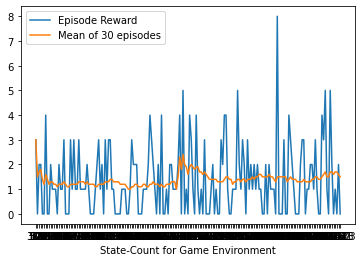

In [19]:
plt.plot(log_reward.count_states, log_reward.episode, label='Episode Reward')
plt.plot(log_reward.count_states, log_reward.mean, label='Mean of 30 episodes')
plt.xlabel('State-Count for Game Environment')
plt.legend()
plt.show()

### Progression de la formation : valeurs Q
Le graphique suivant montre les valeurs Q moyennes de la mémoire de relecture avant chaque exécution de l'optimiseur pour le réseau neuronal. Notez comment les valeurs Q moyennes augmentent rapidement au début, puis elles augmentent assez régulièrement pour 40 millions d'états, après quoi elles tendent toujours vers le haut mais un peu plus irrégulièrement.
L'amélioration rapide au début est probablement due à (1) l'utilisation d'une mémoire de relecture plus petite au début de la formation, de sorte que le réseau de neurones est optimisé plus souvent et que les nouvelles informations sont utilisées plus rapidement, (2) le balayage vers l'arrière de la relecture -mémoire afin que les récompenses soient utilisées pour mettre à jour les valeurs Q pour de nombreux états, au lieu de simplement mettre à jour les valeurs Q pour un seul état, et (3) la mémoire de relecture est équilibrée de sorte qu'au moins la moitié de chaque mini- le lot contient des états dont les valeurs Q ont des erreurs d'estimation élevées pour le réseau de neurones.
Le [original paper from DeepMind](https://arxiv.org/abs/1312.5602) a montré des progrès beaucoup plus lents dans la première phase de la formation, voir la figure 2 dans cet article, mais notez que les valeurs Q ne sont pas directement comparables, peut-être parce qu'elles ont utilisé un facteur d'actualisation plus élevé de 0,99 alors que nous n'avons utilisé que 0,97 ici.

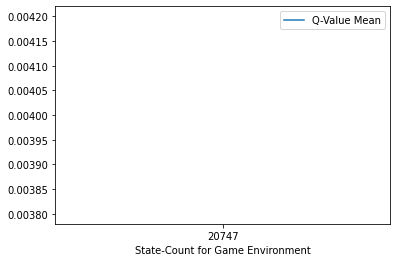

In [20]:
plt.plot(log_q_values.count_states, log_q_values.mean, label='Q-Value Mean')
plt.xlabel('State-Count for Game Environment')
plt.legend()
plt.show()

## Test
Lorsque l'agent et le réseau de neurones sont formés, la soi-disant probabilité epsilon est généralement réduite de 1,0 à 0,1 sur un grand nombre d'étapes, après quoi la probabilité est maintenue fixe à 0,1. Cela signifie que la probabilité est de 0,1 ou 10 % que l'agent sélectionne une action aléatoire à chaque étape, sinon il sélectionnera l'action qui a la valeur Q la plus élevée. C'est ce qu'on appelle la politique gourmande d'epsilon. Le choix de 0,1 pour la probabilité epsilon est un compromis entre la prise d'actions déjà connues pour être bonnes et l'exploration de nouvelles actions qui pourraient conduire à des récompenses encore plus élevées ou à la mort de l'agent.
Pendant les tests, il est courant de réduire encore plus la probabilité epsilon. Nous l'avons défini sur 0,01 comme indiqué ici :

In [21]:
agent.epsilon_greedy.epsilon_testing

0.01

Nous allons maintenant indiquer à l'agent qu'il ne doit plus effectuer de formation en définissant ce booléen :

In [22]:
agent.training = False

Nous avons également réinitialisé les récompenses des épisodes précédents.

In [23]:
agent.reset_episode_rewards()

Nous pouvons rendre l'environnement de jeu à l'écran afin que nous puissions voir l'agent jouer au jeu, en définissant ce booléen :

In [24]:
agent.render = True

Nous pouvons maintenant exécuter un seul épisode en appelant à nouveau la fonction `run()`. Cela devrait ouvrir une nouvelle fenêtre qui montre le jeu joué par l'agent. Au moment d'écrire ces lignes, il n'était pas possible de redimensionner cette minuscule fenêtre, et les développeurs d'OpenAI ne semblaient pas se soucier de cette fonctionnalité qui devrait évidemment être là.

In [29]:
pip install pyglet==1.2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 964 kB 5.2 MB/s 
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0


In [34]:
# agent.run(num_episodes=1)

Error: ignored

### Récompense moyenne

Le jeu est légèrement aléatoire, à la fois en ce qui concerne la sélection des actions en utilisant la politique epsilon-gourmande, mais aussi parce que l'environnement OpenAI Gym répétera toute action entre 2 et 4 fois, avec le nombre choisi au hasard. Ainsi, la récompense d'un épisode n'est pas une estimation précise de la récompense que l'on peut attendre en général de cet agent.
Nous devons exécuter 30 voire 50 épisodes pour obtenir une estimation plus précise de la récompense à laquelle on peut s'attendre.
Nous allons d'abord réinitialiser les récompenses de l'épisode précédent.

In [35]:
agent.reset_episode_rewards()

Nous désactivons le rendu d'écran pour que l'environnement de jeu s'exécute beaucoup plus rapidement.

In [36]:
agent.render = False

Nous pouvons maintenant diffuser 30 épisodes. Cela enregistre les récompenses pour chaque épisode. Cela aurait pu être une bonne idée de désactiver la sortie afin qu'elle n'imprime pas toutes ces lignes - vous pouvez le faire comme exercice.

In [37]:
agent.run(num_episodes=30)

 108:25730	Q-min: 0.001	Q-max: 0.015	Lives: 4	Reward: 0.0	Episode Mean: 0.0
 108:25930	Q-min: 0.103	Q-max: 0.437	Lives: 4	Reward: 1.0	Episode Mean: 0.0
 108:25980	Q-min: 0.067	Q-max: 0.603	Lives: 4	Reward: 2.0	Episode Mean: 0.0
 108:26009	Q-min: 0.002	Q-max: 0.016	Lives: 3	Reward: 2.0	Episode Mean: 0.0
 108:26067	Q-min: 0.093	Q-max: 0.432	Lives: 3	Reward: 3.0	Episode Mean: 0.0
 108:26109	Q-min: 0.010	Q-max: 0.023	Lives: 2	Reward: 3.0	Episode Mean: 0.0
 108:26329	Q-min: 0.005	Q-max: 0.018	Lives: 1	Reward: 3.0	Episode Mean: 0.0
 108:26588	Q-min: -0.134	Q-max: 1.135	Lives: 1	Reward: 4.0	Episode Mean: 0.0
 108:26632	Q-min: 0.014	Q-max: 0.030	Lives: 0	Reward: 4.0	Episode Mean: 0.0
 108:26633	Q-min: 0.015	Q-max: 0.032	Lives: 0	Reward: 4.0	Episode Mean: 4.0
 109:26704	Q-min: -0.000	Q-max: 0.014	Lives: 4	Reward: 0.0	Episode Mean: 4.0
 109:28130	Q-min: 0.171	Q-max: 0.420	Lives: 4	Reward: 1.0	Episode Mean: 4.0
 109:28182	Q-min: -0.013	Q-max: 0.690	Lives: 4	Reward: 2.0	Episode Mean: 4.0
 109:2821

Nous pouvons maintenant imprimer quelques statistiques pour les récompenses des épisodes, qui varient considérablement d'un épisode à l'autre.

In [38]:
rewards = agent.episode_rewards
print("Rewards for {0} episodes:".format(len(rewards)))
print("- Min:   ", np.min(rewards))
print("- Mean:  ", np.mean(rewards))
print("- Max:   ", np.max(rewards))
print("- Stdev: ", np.std(rewards))

Rewards for 30 episodes:
- Min:    0.0
- Mean:   2.033333333333333
- Max:    5.0
- Stdev:  1.5595583420386112


Nous pouvons également tracer un histogramme avec les récompenses de l'épisode.

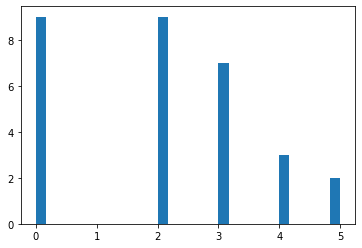

In [39]:
_ = plt.hist(rewards, bins=30)

## Exemples d'états
Nous pouvons tracer des exemples d'états de l'environnement de jeu et des valeurs Q estimées par le réseau de neurones.
Cette fonction d'assistance imprime les valeurs Q pour un index donné dans la mémoire de relecture.

In [40]:
def print_q_values(idx):
    """Print Q-values and actions from the replay-memory at the given index."""

    # Get the Q-values and action from the replay-memory.
    q_values = replay_memory.q_values[idx]
    action = replay_memory.actions[idx]

    print("Action:     Q-Value:")
    print("====================")

    # Print all the actions and their Q-values.
    for i, q_value in enumerate(q_values):
        # Used to display which action was taken.
        if i == action:
            action_taken = "(Action Taken)"
        else:
            action_taken = ""

        # Text-name of the action.
        action_name = agent.get_action_name(i)
            
        print("{0:12}{1:.3f} {2}".format(action_name, q_value,
                                        action_taken))

    # Newline.
    print()

Cette fonction d'assistance trace un état à partir de la mémoire de relecture et imprime éventuellement les valeurs Q.

In [41]:
def plot_state(idx, print_q=True):
    """Plot the state in the replay-memory with the given index."""

    # Get the state from the replay-memory.
    state = replay_memory.states[idx]
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(1, 2)

    # Plot the image from the game-environment.
    ax = axes.flat[0]
    ax.imshow(state[:, :, 0], vmin=0, vmax=255,
              interpolation='lanczos', cmap='gray')

    # Plot the motion-trace.
    ax = axes.flat[1]
    ax.imshow(state[:, :, 1], vmin=0, vmax=255,
              interpolation='lanczos', cmap='gray')

    # This is necessary if we show more than one plot in a single Notebook cell.
    plt.show()
    
    # Print the Q-values.
    if print_q:
        print_q_values(idx=idx)

La mémoire de relecture a de la place pour 200 000 états, mais elle n'est que partiellement pleine depuis l'appel ci-dessus à `agent.run(num_episodes=1)`. C'est le nombre d'états réellement utilisés.

In [42]:
num_used = replay_memory.num_used
num_used

4757

Obtenez les valeurs Q de la mémoire de relecture qui sont réellement utilisées.

In [43]:
q_values = replay_memory.q_values[0:num_used, :]

Pour chaque état, calculez les valeurs Q min / max et leur différence. Cela sera utilisé pour rechercher des états intéressants dans les sections suivantes.

In [44]:
q_values_min = q_values.min(axis=1)
q_values_max = q_values.max(axis=1)
q_values_dif = q_values_max - q_values_min

### Exemples d'états : récompense la plus élevée
Cet exemple montre les états entourant l'état avec la récompense la plus élevée.
Pendant l'entraînement, nous limitons les récompenses à la plage [-1, 1], donc cela n'obtient en gros que le premier état qui a une récompense de 1.

In [45]:
idx = np.argmax(replay_memory.rewards)
idx

41

Cet état correspond à l'endroit où la balle touche le mur et l'agent marque donc un point.
Nous pouvons montrer les états environnants avant et après cet état. Notez que les valeurs Q sont très proches pour les différentes actions, car à ce stade, peu importe ce que fait l'agent car la récompense est déjà garantie. Mais notez comment les valeurs Q diminuent considérablement après que la balle a touché le mur et qu'un point a été marqué.
Notez également que l'agent utilise la politique gourmande Epsilon pour effectuer des actions, il y a donc une faible probabilité qu'une action aléatoire soit entreprise au lieu de l'action avec la valeur Q la plus élevée.

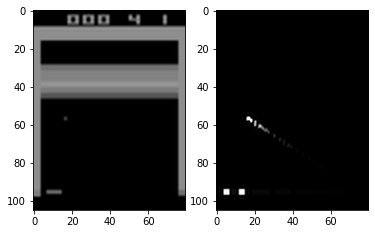

Action:     Q-Value:
NOOP        0.264 
FIRE        0.091 (Action Taken)
RIGHT       0.267 
LEFT        0.082 



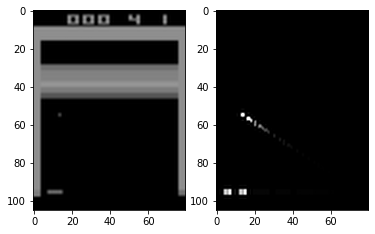

Action:     Q-Value:
NOOP        0.713 
FIRE        0.152 (Action Taken)
RIGHT       -0.000 
LEFT        0.004 



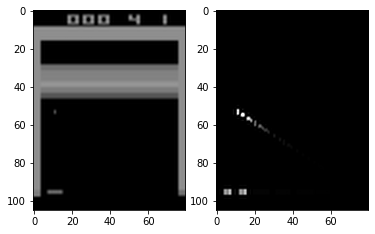

Action:     Q-Value:
NOOP        0.484 
FIRE        0.110 
RIGHT       0.031 (Action Taken)
LEFT        0.125 



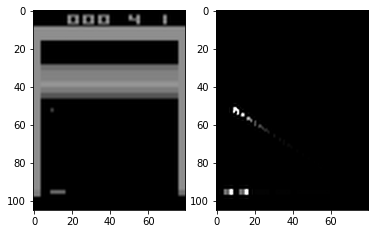

Action:     Q-Value:
NOOP        0.127 (Action Taken)
FIRE        0.002 
RIGHT       0.048 
LEFT        0.645 



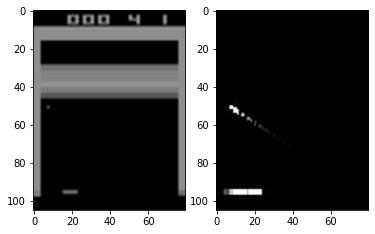

Action:     Q-Value:
NOOP        -0.022 
FIRE        -0.013 (Action Taken)
RIGHT       0.043 
LEFT        0.824 



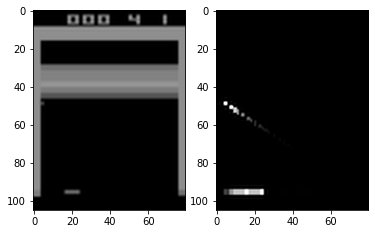

Action:     Q-Value:
NOOP        0.140 (Action Taken)
FIRE        0.043 
RIGHT       0.108 
LEFT        0.519 



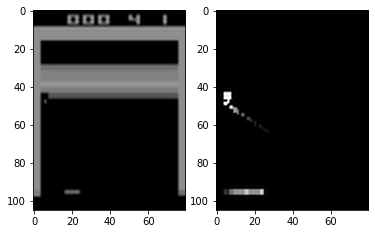

Action:     Q-Value:
NOOP        0.055 
FIRE        0.057 (Action Taken)
RIGHT       0.053 
LEFT        0.034 



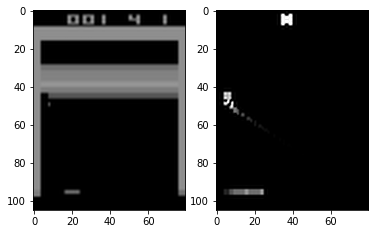

Action:     Q-Value:
NOOP        0.059 
FIRE        0.037 (Action Taken)
RIGHT       0.056 
LEFT        0.046 



In [46]:
for i in range(-5, 3):
    plot_state(idx=idx+i)

### Exemple : Valeur Q la plus élevée
Cet exemple montre les états entourant celui avec les valeurs Q les plus élevées. Cela signifie que l'agent s'attend à ce que plusieurs points soient marqués dans les étapes suivantes. Notez que les valeurs Q diminuent considérablement après que les points ont été marqués.

In [47]:
idx = np.argmax(q_values_max)
idx

3088

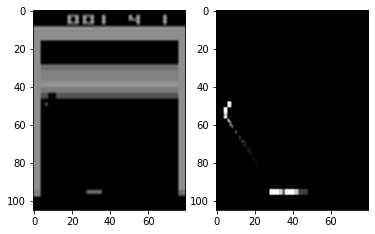

Action:     Q-Value:
NOOP        -0.050 (Action Taken)
FIRE        1.231 
RIGHT       0.164 
LEFT        -0.072 



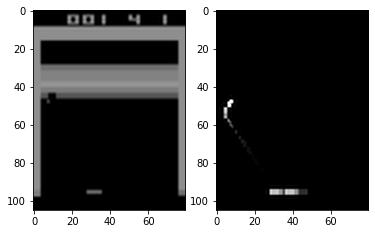

Action:     Q-Value:
NOOP        -0.040 
FIRE        0.435 
RIGHT       0.783 
LEFT        -0.015 (Action Taken)



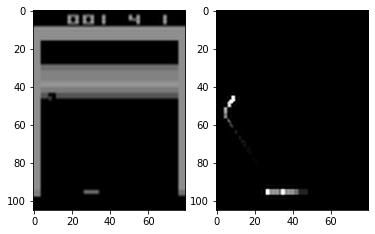

Action:     Q-Value:
NOOP        0.129 
FIRE        0.187 
RIGHT       0.722 (Action Taken)
LEFT        0.146 



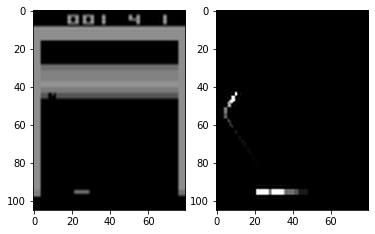

Action:     Q-Value:
NOOP        0.535 (Action Taken)
FIRE        0.083 
RIGHT       0.262 
LEFT        0.126 



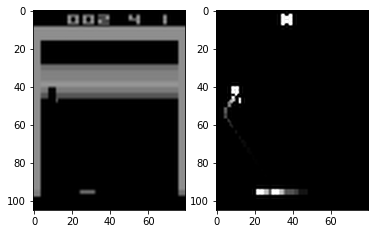

Action:     Q-Value:
NOOP        0.013 
FIRE        0.004 (Action Taken)
RIGHT       0.034 
LEFT        0.026 



In [48]:
for i in range(0, 5):
    plot_state(idx=idx+i)

### Exemple : Perte de vie
Cet exemple montre les états menant à une perte de vie pour l'agent.

In [49]:
idx = np.argmax(replay_memory.end_life)
idx

82

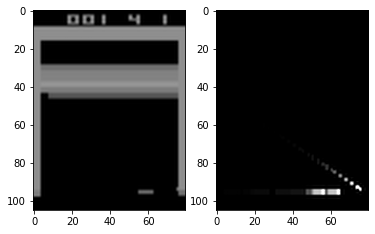

Action:     Q-Value:
NOOP        0.119 
FIRE        0.094 
RIGHT       0.152 
LEFT        0.073 (Action Taken)



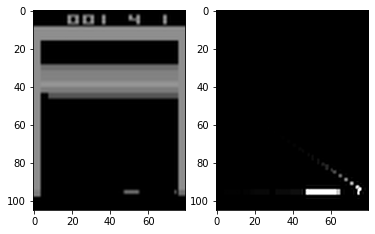

Action:     Q-Value:
NOOP        0.026 
FIRE        0.022 
RIGHT       0.039 (Action Taken)
LEFT        0.029 



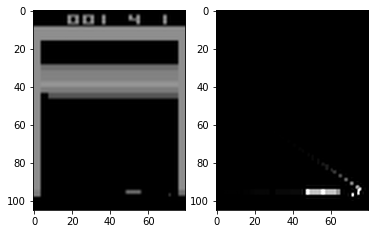

Action:     Q-Value:
NOOP        0.012 
FIRE        0.008 
RIGHT       0.019 
LEFT        0.010 (Action Taken)



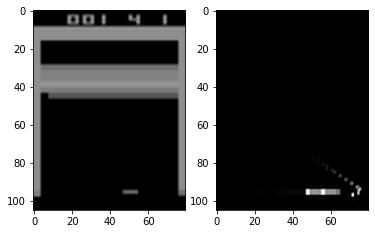

Action:     Q-Value:
NOOP        0.010 
FIRE        0.006 
RIGHT       0.018 (Action Taken)
LEFT        0.008 



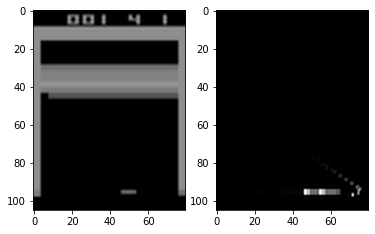

Action:     Q-Value:
NOOP        0.002 
FIRE        -0.003 
RIGHT       0.011 
LEFT        -0.002 (Action Taken)



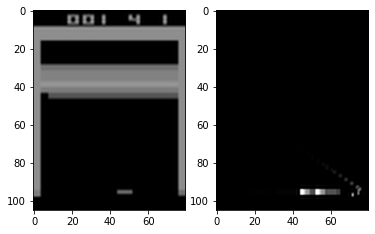

Action:     Q-Value:
NOOP        0.003 
FIRE        -0.000 (Action Taken)
RIGHT       0.013 
LEFT        -0.001 



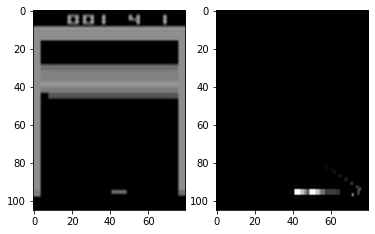

Action:     Q-Value:
NOOP        0.054 (Action Taken)
FIRE        0.120 
RIGHT       0.065 
LEFT        0.062 



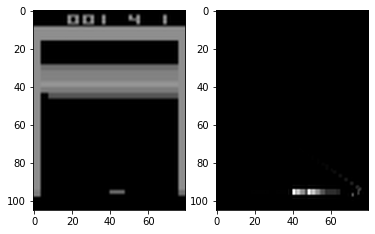

Action:     Q-Value:
NOOP        0.006 
FIRE        0.001 
RIGHT       0.014 
LEFT        0.002 (Action Taken)



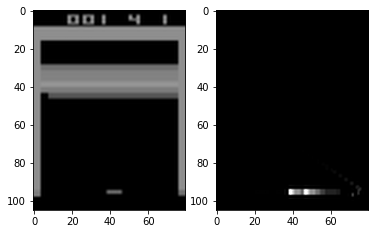

Action:     Q-Value:
NOOP        0.020 
FIRE        0.017 
RIGHT       0.029 
LEFT        0.018 (Action Taken)



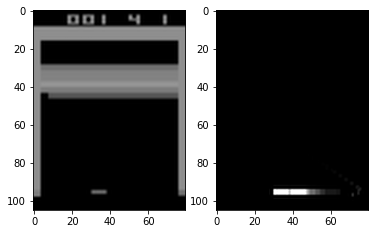

Action:     Q-Value:
NOOP        0.015 
FIRE        0.022 
RIGHT       0.085 (Action Taken)
LEFT        0.025 



In [50]:
for i in range(-10, 0):
    plot_state(idx=idx+i)

### Exemple : la plus grande différence dans les valeurs Q
Cet exemple montre l'état où il y a la plus grande différence dans les valeurs Q, ce qui signifie que l'agent pense qu'une action sera beaucoup plus bénéfique qu'une autre. Mais parce que l'agent utilise la politique gourmande Epsilon, il sélectionne parfois une action aléatoire à la place.

In [51]:
idx = np.argmax(q_values_dif)
idx

3088

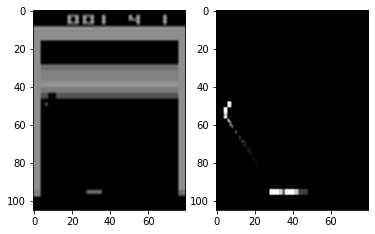

Action:     Q-Value:
NOOP        -0.050 (Action Taken)
FIRE        1.231 
RIGHT       0.164 
LEFT        -0.072 



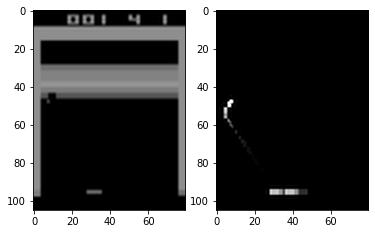

Action:     Q-Value:
NOOP        -0.040 
FIRE        0.435 
RIGHT       0.783 
LEFT        -0.015 (Action Taken)



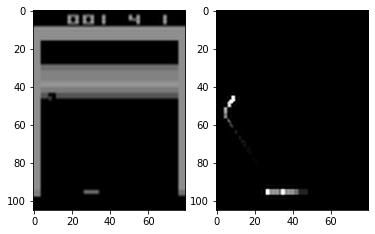

Action:     Q-Value:
NOOP        0.129 
FIRE        0.187 
RIGHT       0.722 (Action Taken)
LEFT        0.146 



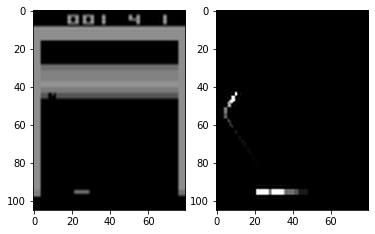

Action:     Q-Value:
NOOP        0.535 (Action Taken)
FIRE        0.083 
RIGHT       0.262 
LEFT        0.126 



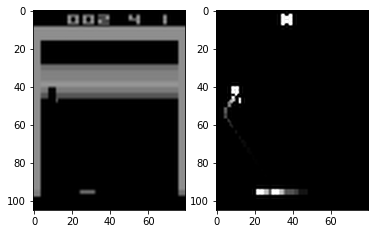

Action:     Q-Value:
NOOP        0.013 
FIRE        0.004 (Action Taken)
RIGHT       0.034 
LEFT        0.026 



In [52]:
for i in range(0, 5):
    plot_state(idx=idx+i)

### Exemple : la plus petite différence dans les valeurs Q
Cet exemple montre l'état où il y a la plus petite différence dans les valeurs Q, ce qui signifie que l'agent pense que l'action qu'il sélectionne n'a pas vraiment d'importance, car ils ont tous à peu près les mêmes attentes pour les récompenses futures.
Le réseau de neurones estime ces valeurs Q et elles ne sont pas précises. Les différences dans les valeurs Q peuvent être si faibles qu'elles se situent dans la plage d'erreur des estimations.

In [53]:
idx = np.argmin(q_values_dif)
idx

1153

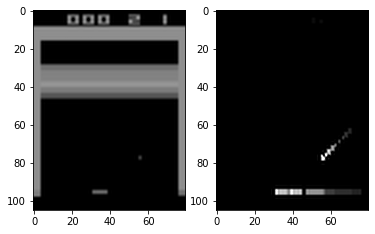

Action:     Q-Value:
NOOP        0.042 
FIRE        0.042 
RIGHT       0.041 (Action Taken)
LEFT        0.039 



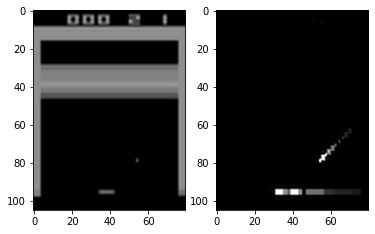

Action:     Q-Value:
NOOP        0.029 
FIRE        0.025 
RIGHT       0.035 (Action Taken)
LEFT        0.024 



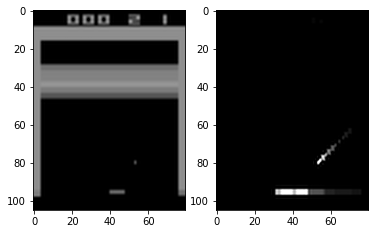

Action:     Q-Value:
NOOP        0.024 (Action Taken)
FIRE        0.020 
RIGHT       0.030 
LEFT        0.024 



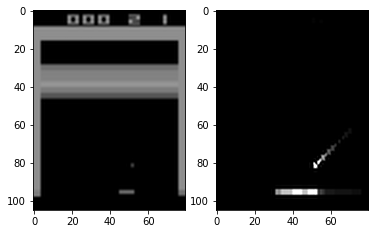

Action:     Q-Value:
NOOP        0.024 
FIRE        0.024 (Action Taken)
RIGHT       0.032 
LEFT        0.021 



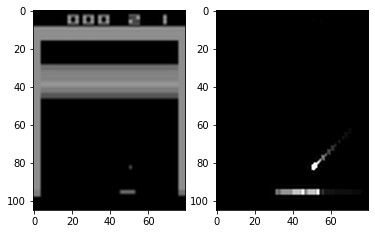

Action:     Q-Value:
NOOP        0.023 (Action Taken)
FIRE        0.019 
RIGHT       0.029 
LEFT        0.021 



In [54]:
for i in range(0, 5):
    plot_state(idx=idx+i)

## Sortie des couches convolutionnelles
Les sorties des couches convolutionnelles peuvent être tracées afin que nous puissions voir comment les images de l'environnement de jeu sont traitées par le réseau de neurones.
Il s'agit de la fonction d'assistance pour tracer la sortie de la couche convolutive avec le nom donné, lors de la saisie de l'état donné à partir de la mémoire de relecture.

In [55]:
def plot_layer_output(model, layer_name, state_index, inverse_cmap=False):
    """
    Plot the output of a convolutional layer.

    :param model: An instance of the NeuralNetwork-class.
    :param layer_name: Name of the convolutional layer.
    :param state_index: Index into the replay-memory for a state that
                        will be input to the Neural Network.
    :param inverse_cmap: Boolean whether to inverse the color-map.
    """

    # Get the given state-array from the replay-memory.
    state = replay_memory.states[state_index]
    
    # Get the output tensor for the given layer inside the TensorFlow graph.
    # This is not the value-contents but merely a reference to the tensor.
    layer_tensor = model.get_layer_tensor(layer_name=layer_name)
    
    # Get the actual value of the tensor by feeding the state-data
    # to the TensorFlow graph and calculating the value of the tensor.
    values = model.get_tensor_value(tensor=layer_tensor, state=state)

    # Number of image channels output by the convolutional layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))

    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids, figsize=(10, 10))

    print("Dim. of each image:", values.shape)
    
    if inverse_cmap:
        cmap = 'gray_r'
    else:
        cmap = 'gray'

    # Plot the outputs of all the channels in the conv-layer.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i < num_images:
            # Get the image for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap=cmap)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


### État du jeu
C'est l'état qui est entré dans le réseau neuronal. L'image de gauche est la dernière image de l'environnement de jeu. L'image de droite est la trace de mouvement traitée qui montre les trajectoires des objets dans l'environnement du jeu.

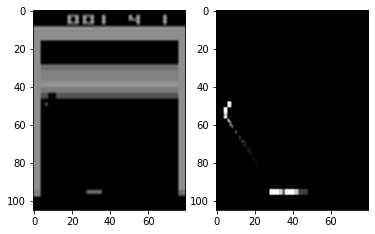

In [56]:
idx = np.argmax(q_values_max)
plot_state(idx=idx, print_q=False)

### Sortie de la couche convolutive 1
Cela montre les images qui sont produites par la 1ère couche convolutive, lors de la saisie de l'état ci-dessus dans le réseau neuronal. Il y a 16 canaux de sortie de cette couche convolutive.
Notez que vous pouvez inverser les couleurs en définissant `inverse_cmap=True` dans les paramètres de cette fonction.

Dim. of each image: (1, 53, 40, 16)


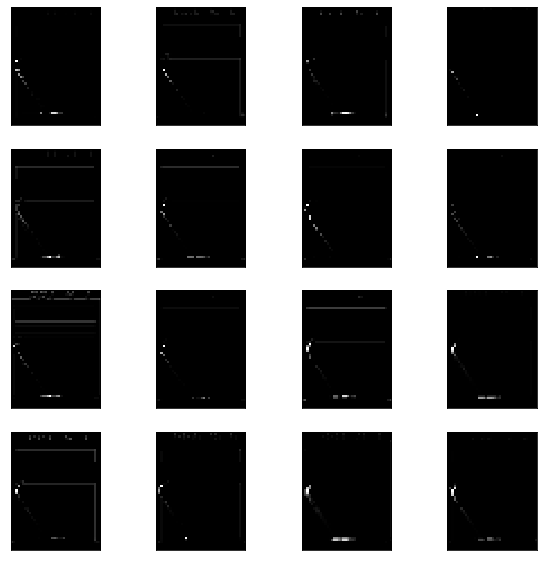

In [57]:
plot_layer_output(model=model, layer_name='layer_conv1', state_index=idx, inverse_cmap=False)

### Sortie de la couche convolutive 2
Ce sont les images produites par la 2ème couche convolutive, lors de la saisie de l'état ci-dessus dans le réseau de neurones. Il y a 32 canaux de sortie de cette couche convolutive.

Dim. of each image: (1, 27, 20, 32)


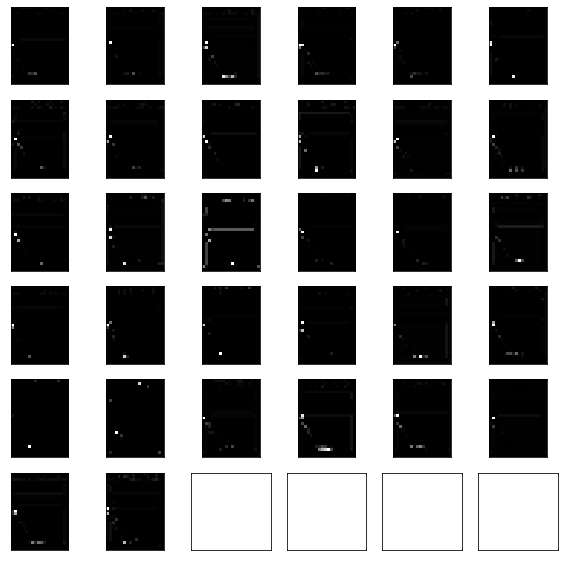

In [58]:
plot_layer_output(model=model, layer_name='layer_conv2', state_index=idx, inverse_cmap=False)

### Sortie de la couche convolutive 3
Ce sont les images produites par la 3ème couche convolutive, lors de la saisie de l'état ci-dessus dans le réseau de neurones. Il y a 64 canaux de sortie de cette couche convolutive.
Toutes ces images sont aplaties en un tableau unidimensionnel (ou tenseur) qui est ensuite utilisé comme entrée d'une couche entièrement connectée dans le réseau de neurones.
Au cours du processus de formation, le réseau de neurones a appris quels filtres convolutifs appliquer aux images de l'environnement de jeu afin de produire ces images, car ils se sont avérés utiles lors de l'estimation des valeurs Q.
Pouvez-vous voir ce que le réseau de neurones a appris à détecter dans ces images ?

Dim. of each image: (1, 27, 20, 64)


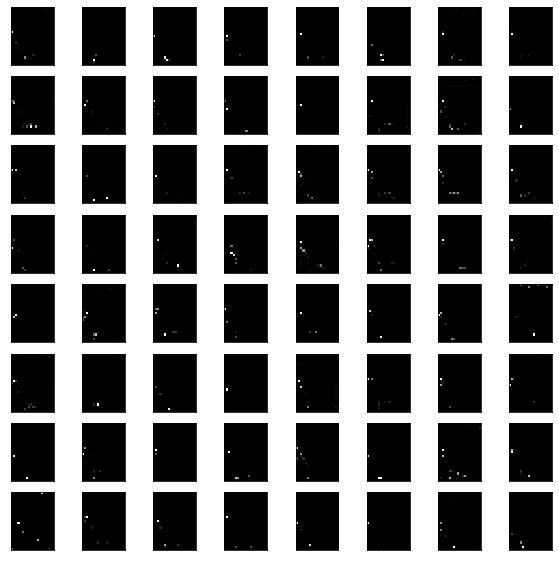

In [59]:
plot_layer_output(model=model, layer_name='layer_conv3', state_index=idx, inverse_cmap=False)

## Poids pour les couches convolutionnelles
Nous pouvons également tracer les poids des couches convolutionnelles dans le réseau de neurones. Ce sont les poids qui sont optimisés afin d'améliorer la capacité du réseau de neurones à estimer les valeurs Q. Le tutoriel #02 explique plus en détail ce que sont les poids convolutionnels.
Il existe également des pondérations pour les couches entièrement connectées, mais elles ne sont pas présentées ici.
Il s'agit de la fonction d'assistance pour tracer les poids d'une couche convolutive.

In [60]:
def plot_conv_weights(model, layer_name, input_channel=0):
    """
    Plot the weights for a convolutional layer.
    
    :param model: An instance of the NeuralNetwork-class.
    :param layer_name: Name of the convolutional layer.
    :param input_channel: Plot the weights for this input-channel.
    """

    # Get the variable for the weights of the given layer.
    # This is a reference to the variable inside TensorFlow,
    # not its actual value.
    weights_variable = model.get_weights_variable(layer_name=layer_name)
    
    # Retrieve the values of the weight-variable from TensorFlow.
    # The format of this 4-dim tensor is determined by the
    # TensorFlow API. See Tutorial #02 for more details.
    w = model.get_variable_value(variable=weights_variable)

    # Get the weights for the given input-channel.
    w_channel = w[:, :, input_channel, :]
    
    # Number of output-channels for the conv. layer.
    num_output_channels = w_channel.shape[2]

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w_channel)
    w_max = np.max(w_channel)

    # This is used to center the colour intensity at zero.
    abs_max = max(abs(w_min), abs(w_max))

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w_min, w_max))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w_channel.mean(),
                                                 w_channel.std()))

    # Number of grids to plot.
    # Rounded-up, square-root of the number of output-channels.
    num_grids = math.ceil(math.sqrt(num_output_channels))

    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i < num_output_channels:
            # Get the weights for the i'th filter of this input-channel.
            img = w_channel[:, :, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Poids pour la couche convolutive 1
Ce sont les poids de la première couche convolutive du réseau de neurones, par rapport au premier canal d'entrée de l'état. Autrement dit, ce sont les poids qui sont utilisés sur l'image de l'environnement de jeu. Certaines statistiques de base sont également présentées.
Notez comment les poids sont plus négatifs (bleu) que positifs (rouge). On ne sait pas pourquoi cela se produit car ces poids sont trouvés par optimisation. Il est apparemment avantageux pour les couches suivantes d'avoir ce traitement avec plus de poids négatifs dans la première couche convolutive.

Min:  -0.07662, Max:   0.04205
Mean: -0.00869, Stdev: 0.02335


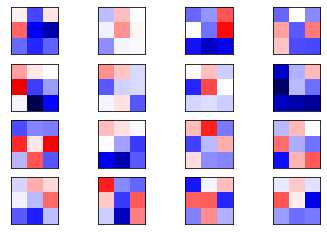

In [61]:
plot_conv_weights(model=model, layer_name='layer_conv1', input_channel=0)

Nous pouvons également tracer les poids convolutifs pour le deuxième canal d'entrée, c'est-à-dire la trace de mouvement de l'environnement de jeu. Une fois de plus, nous voyons que les poids négatifs (bleu) ont une ampleur beaucoup plus grande que les poids positifs (rouge).

Min:  -0.10650, Max:   0.05432
Mean: -0.00413, Stdev: 0.03243


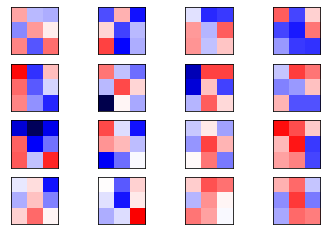

In [62]:
plot_conv_weights(model=model, layer_name='layer_conv1', input_channel=1)

### Poids pour la couche convolutive 2
Ce sont les poids de la 2ème couche convolutive dans le réseau de neurones. Il y a 16 canaux d'entrée et 32 ​​canaux de sortie de cette couche. Vous pouvez modifier le numéro du canal d'entrée pour voir les poids associés.
Notez comment les poids sont plus équilibrés entre le positif (rouge) et le négatif (bleu) par rapport aux poids de la 1ère couche convolutive ci-dessus.

Min:  -0.08586, Max:   0.05728
Mean: -0.00414, Stdev: 0.02753


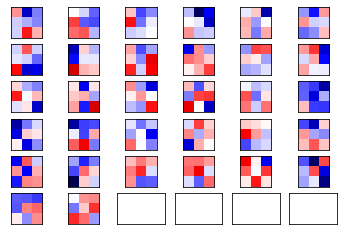

In [63]:
plot_conv_weights(model=model, layer_name='layer_conv2', input_channel=0)

### Poids pour la couche convolutive 3
Ce sont les poids de la 3ème couche convolutive dans le réseau de neurones. Il y a 32 canaux d'entrée et 64 canaux de sortie de cette couche. Vous pouvez modifier le numéro du canal d'entrée pour voir les poids associés.
Notez à nouveau comment les poids sont plus équilibrés entre le positif (rouge) et le négatif (bleu) par rapport aux poids de la 1ère couche convolutive ci-dessus.

Min:  -0.08209, Max:   0.05821
Mean: -0.00886, Stdev: 0.02643


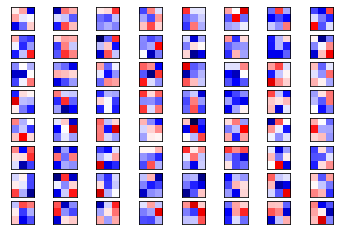

In [64]:
plot_conv_weights(model=model, layer_name='layer_conv3', input_channel=0)

## Discussion
Nous avons formé un agent pour jouer assez bien aux vieux jeux Atari en utilisant l'apprentissage par renforcement. Les améliorations récentes apportées à l'algorithme d'entraînement ont considérablement amélioré les performances. Mais est-ce une véritable intelligence humaine ? La réponse est clairement non!
L'apprentissage par renforcement dans sa forme actuelle est un algorithme numérique brut pour connecter des images visuelles, des actions, des récompenses et des pénalités lorsqu'il y a un décalage entre les signaux. L'apprentissage est basé sur des essais et des erreurs et ne peut pas faire de raisonnement logique comme un humain. L'agent n'a aucun sens du "soi" alors qu'un humain a une compréhension de la partie de l'environnement de jeu qu'il contrôle, donc un humain peut raisonner logiquement comme ceci : "(A) je contrôle la pagaie, et (B) je doit éviter de mourir, ce qui se produit lorsque la balle passe devant la raquette, donc (C) je dois déplacer la raquette pour frapper la balle, et (D) cela marque automatiquement des points lorsque la balle fracasse des briques dans le mur". Un humain apprendrait d'abord ces règles logiques de base du jeu - puis essaierait d'affiner la coordination œil-main pour mieux jouer au jeu. L'apprentissage par renforcement n'a aucune compréhension réelle de ce qui se passe dans le jeu et travaille simplement à améliorer la coordination œil-main jusqu'à ce qu'il ait de la chance et fasse ce qu'il faut pour marquer plus de points.
De plus, la formation de l'algorithme d'apprentissage par renforcement a nécessité près de 150 heures de calcul qui ont joué le jeu à grande vitesse. Si le jeu avait été joué à des vitesses normales en temps réel, il aurait fallu plus de 1700 heures pour former l'agent, soit plus de 70 jours et nuits.
Le raisonnement logique permettrait un apprentissage beaucoup plus rapide que l'apprentissage par renforcement, et il serait capable de résoudre des problèmes beaucoup plus compliqués que la simple coordination œil-main. Je suis sceptique quant à la capacité de quelqu'un à créer une véritable intelligence humaine à partir d'algorithmes d'apprentissage par renforcement.
Cela signifie-t-il que l'apprentissage par renforcement ne vaut rien ? Non, il a des applications réelles qui ne peuvent actuellement pas être résolues par d'autres méthodes.
Un autre point de critique est l'utilisation des réseaux de neurones. La majorité de la recherche en apprentissage par renforcement est en fait consacrée à essayer de stabiliser la formation du réseau de neurones en utilisant diverses astuces. C'est une perte de temps de recherche et indique fortement que les réseaux de neurones ne sont peut-être pas un très bon modèle d'apprentissage automatique par rapport au cerveau humain.

## Exercices et idées de recherche
Vous trouverez ci-dessous des suggestions d'exercices et d'expériences qui peuvent vous aider à améliorer vos compétences avec TensorFlow et l'apprentissage par renforcement. Certaines de ces idées peuvent facilement être étendues à des problèmes de recherche complets qui aideraient la communauté si vous pouviez les résoudre.
Vous devez conserver un journal de vos expériences, décrivant pour chaque expérience les paramètres que vous avez essayés et les résultats. Vous devez également enregistrer le code source et les points de contrôle / fichiers journaux.
L'exécution de ces expériences prend tellement de temps, alors partagez vos résultats avec le reste de la communauté. Même si une expérience n'a rien donné d'utile, elle sera utile aux autres pour qu'ils sachent qu'il ne faut pas refaire la même expérience.
[Thread on GitHub for discussing these experiments](https://github.com/Hvass-Labs/TensorFlow-Tutorials/issues/32)
Vous voudrez peut-être sauvegarder ce bloc-notes et les autres fichiers avant d'apporter des modifications.
Vous trouverez peut-être utile d'ajouter plus de paramètres de ligne de commande à `reinforcement_learning.py` afin de ne pas avoir à modifier le code source pour tester d'autres paramètres.
* Modifiez la probabilité epsilon pendant les tests, par ex. 0,001 ou 0,05. Laquelle donne les meilleurs résultats ? Pourriez-vous utiliser cette valeur pendant l'entraînement ? Pourquoi pas?
* Essayez de changer l'environnement de jeu en Space Invaders et relancez ce Notebook. Les hyper-paramètres tels que le taux d'apprentissage ont été réglés pour Breakout. Pouvez-vous créer une sorte de taux d'apprentissage adaptatif qui fonctionnerait mieux à la fois pour Breakout et Space Invaders? Qu'en est-il des autres hyper-paramètres ? Et les autres jeux ?
* Essayez différentes architectures pour le réseau de neurones. Vous devrez recommencer la formation car les points de contrôle ne peuvent pas être réutilisés pour d'autres architectures. Vous devrez former l'agent pendant plusieurs jours à chaque nouvelle architecture afin de bien évaluer ses performances.
* La mémoire de relecture supprime toutes les données après optimisation du réseau de neurones. Pouvez-vous faire en sorte qu'il réutilise les données d'une manière ou d'une autre ? La classe ReplayMemory a la fonction `estimate_all_q_values()` qui peut être utile.
* La récompense est limitée à -1 et 1 dans la fonction `ReplayMemory.add()` afin de stabiliser l'entraînement. Cela signifie que l'agent ne peut pas faire la distinction entre les petites et les grandes récompenses. Pouvez-vous utiliser la normalisation par lots pour résoudre ce problème, afin de pouvoir utiliser les valeurs de récompense réelles ?
* Pouvez-vous améliorer la formation en ajoutant une régularisation L2 ou un abandon ?
* Essayez d'utiliser d'autres optimiseurs pour le réseau de neurones. Cela aide-t-il à la vitesse d'entraînement ou à la stabilité ?
* Laissez l'agent effectuer jusqu'à 30 actions aléatoires au début de chaque nouvel épisode. Ceci est utilisé dans certains articles de recherche pour randomiser davantage l'environnement de jeu, afin que l'agent ne puisse pas mémoriser la première séquence d'actions.
* Essayez de sauvegarder le jeu à intervalles réguliers. Si l'agent meurt, vous pouvez recharger la dernière partie sauvegardée. Cela aiderait-il à former l'agent plus rapidement et mieux, car il n'a pas besoin de jouer le jeu depuis le début ?
* Certaines actions invalides sont disponibles pour l'agent dans OpenAI Gym. Est-ce que cela améliore la formation si vous n'autorisez que les actions valides de l'environnement de jeu ?
* Le MotionTracer fonctionne-t-il pour d'autres jeux ? Pouvez-vous améliorer le MotionTracer ?
* Essayez d'utiliser les 4 dernières images du jeu au lieu du MotionTracer.
* Essayez des tailles plus grandes et plus petites pour la mémoire de lecture.
* Essayez des taux de remise plus grands et plus petits pour mettre à jour les valeurs Q.
* Si vous regardez attentivement les états et les actions qui s'affichent ci-dessus, vous remarquerez que l'agent a parfois effectué des actions qui ne correspondent pas au mouvement de la palette. Par exemple, l'action peut être à GAUCHE mais soit la raquette n'a pas bougé du tout, soit elle s'est déplacée à droite à la place. Est-ce un bogue dans le code source de ce didacticiel, ou est-ce un bogue dans OpenAI Gym, ou est-ce un bogue dans l'environnement d'apprentissage Atari sous-jacent ? Est-ce que ça importe?

## Licence (MIT)
Copyright (c) 2017 par [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
L'autorisation est accordée, gratuitement, à toute personne obtenant une copie de ce logiciel et des fichiers de documentation associés (le "Logiciel"), de traiter le Logiciel sans restriction, y compris, sans limitation, les droits d'utilisation, de copie, de modification, de fusion , publier, distribuer, concéder en sous-licence et/ou vendre des copies du Logiciel, et permettre aux personnes à qui le Logiciel est fourni de le faire, sous réserve des conditions suivantes :
L'avis de droit d'auteur ci-dessus et cet avis d'autorisation doivent être inclus dans toutes les copies ou parties substantielles du Logiciel.
LE LOGICIEL EST FOURNI "TEL QUEL", SANS GARANTIE D'AUCUNE SORTE, EXPRESSE OU IMPLICITE, Y COMPRIS, MAIS SANS S'Y LIMITER, LES GARANTIES DE QUALITÉ MARCHANDE, D'ADÉQUATION À UN USAGE PARTICULIER ET D'ABSENCE DE CONTREFAÇON. EN AUCUN CAS LES AUTEURS OU LES DÉTENTEURS DU COPYRIGHT NE SERONT RESPONSABLES DE TOUTE RÉCLAMATION, DOMMAGE OU AUTRE RESPONSABILITÉ, QUE CE SOIT DANS UNE ACTION CONTRACTUELLE, DÉLICTUELLE OU AUTRE, DÉCOULANT DE, DE OU EN RELATION AVEC LE LOGICIEL OU L'UTILISATION OU D'AUTRES TRANSACTIONS DANS LE LOGICIEL.